In [27]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import img_to_array, load_img
import scipy
from tensorflow.keras.applications import VGG16

# Dataset Preparation

## Downloading

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech

 99% 330M/333M [00:06<00:00, 71.9MB/s]
100% 333M/333M [00:06<00:00, 54.2MB/s]


In [ ]:
!unzip "/content/shanghaitech.zip" -d "/content/dataset/"

## Target Maps Preparation

In [4]:
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
SUBSAMPLING_FACTOR=IN_X//OUT_X

In [5]:
def gauss_distribution(x,u=0,sigma=10):
    return np.expand_dims(1/(np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(0.5)*(((x-u)/sigma)**2)),axis=0)

In [17]:
def get_density_map_gaussian(im,points,gaussian_radius=4):
    density_map=np.zeros((OUT_X,OUT_Y))
    w,h=OUT_Y,OUT_X
    num_gt=len(points)

    for point in points:
        point=np.round(point).astype(int)
        point[0],point[1]=min(h-1,point[1]),min(w-1,point[0])
        x=np.linspace(-gaussian_radius,gaussian_radius,(gaussian_radius*2)+1)
        gaussian_map=np.multiply(gauss_distribution(x),gauss_distribution(x).T)
        gaussian_map/=np.sum(gaussian_map)

        x_left,x_right,y_up,y_down=0,gaussian_map.shape[1],0,gaussian_map.shape[0]
        if point[1]<gaussian_radius:
            x_left=gaussian_radius-point[1]
        if point[0]<gaussian_radius:
            y_up=gaussian_radius-point[0]
        if point[1]+gaussian_radius>=w:
            x_right=gaussian_map.shape[1]-(gaussian_radius+point[1]-w)-1
        if point[0]+gaussian_radius>=h:
            y_down=gaussian_map.shape[0]-(gaussian_radius+point[0]-h)-1
        density_map[
            max(0,point[0]-gaussian_radius):min(density_map.shape[0],point[0]+gaussian_radius+1),
            max(0,point[1]-gaussian_radius):min(density_map.shape[1],point[1]+gaussian_radius+1),
        ]+=gaussian_map[y_up:y_down,x_left:x_right]
    density_map/=np.sum(density_map/len(points))
    return density_map

In [7]:
IN_H=IN_X=768
IN_W=IN_Y=1024

In [12]:
train_images='/content/dataset/ShanghaiTech/part_B/train_data/images/'
train_maps='/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/'
val_images='/content/dataset/ShanghaiTech/part_B/test_data/images/'
val_maps='/content/dataset/ShanghaiTech/part_B/test_data/ground-truth/'

LR=1e-4
BATCH_SIZE=1
EPOCH=1000

In [8]:
def get_rand(min_val, max_val):
  return tf.random.uniform((1,), minval = min_val, maxval = max_val, dtype=tf.int32,)[0].numpy()

In [9]:
def get_patches(IN_H, IN_W):
  patch_1 = np.array([IN_H//8, IN_W//8, 0, 0])
  patch_2 = np.array([IN_H//2, IN_W//8, 0, 0])
  patch_3 = np.array([IN_H//8, IN_W//2, 0, 0])
  patch_4 = np.array([IN_H//2, IN_W//2, 0, 0])

  patch_5= np.array([get_rand(0, int(IN_H*0.75)), get_rand(0, int(IN_W*0.75)), 0, 0])
  patch_6= np.array([get_rand(0, int(IN_H*0.75)), get_rand(0, int(IN_W*0.75)), 0, 0])
  patch_7= np.array([get_rand(0, int(IN_H*0.75)), get_rand(0, int(IN_W*0.75)), 0, 0])
  patch_8= np.array([get_rand(0, int(IN_H*0.75)), get_rand(0, int(IN_W*0.75)), 0, 0])
  patch_9= np.array([get_rand(0, int(IN_H*0.75)), get_rand(0, int(IN_W*0.75)), 0, 0])

  patch_1[2], patch_1[3] = patch_1[0] + IN_H//4, patch_1[1] + IN_W//4
  patch_2[2], patch_2[3] = patch_2[0] + IN_H//4, patch_2[1] + IN_W//4
  patch_3[2], patch_3[3] = patch_3[0] + IN_H//4, patch_3[1] + IN_W//4
  patch_4[2], patch_4[3] = patch_4[0] + IN_H//4, patch_4[1] + IN_W//4

  patch_5[2], patch_5[3] = patch_5[0] + IN_H//4, patch_5[1] + IN_W//4
  patch_6[2], patch_6[3] = patch_6[0] + IN_H//4, patch_6[1] + IN_W//4
  patch_7[2], patch_7[3] = patch_7[0] + IN_H//4, patch_7[1] + IN_W//4
  patch_8[2], patch_8[3] = patch_8[0] + IN_H//4, patch_8[1] + IN_W//4
  patch_9[2], patch_9[3] = patch_9[0] + IN_H//4, patch_9[1] + IN_W//4

  patches = np.array([patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8, patch_9])
  patches = tf.random.shuffle(patches)

  return patches, patches//8

patch_1, patch_2= get_patches(IN_H, IN_W)
print (patch_1, patch_2)

tf.Tensor(
[[202 119 394 375]
 [384 128 576 384]
 [ 96 128 288 384]
 [ 96 512 288 768]
 [314 368 506 624]
 [384 512 576 768]
 [180 109 372 365]
 [143  95 335 351]
 [454  11 646 267]], shape=(9, 4), dtype=int64) tf.Tensor(
[[25 14 49 46]
 [48 16 72 48]
 [12 16 36 48]
 [12 64 36 96]
 [39 46 63 78]
 [48 64 72 96]
 [22 13 46 45]
 [17 11 41 43]
 [56  1 80 33]], shape=(9, 4), dtype=int64)


In [18]:
IN = "IMG_245"

im_array = img_to_array(load_img(train_images + IN + ".jpg", target_size = (IN_X, IN_Y)))

im_array/= 255.0

im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

im_patch = []
for i in range(9):
  im_patch.append(im_array[patch_1[i][0]:patch_1[i][2], patch_1[i][1]:patch_1[i][3]])

im_patch = tf.constant(im_patch)

mat = scipy.io.loadmat(train_maps + 'GT_' +IN+ ".mat")

points=mat['image_info'][0][0][0][0][0]
points/= SUBSAMPLING_FACTOR

y = get_density_map_gaussian(im_array, points, gaussian_radius= 5, )

map_patch = []

for i in range(9):
  map_patch.append(y[patch_2[i][0]:patch_2[i][2], patch_2[i][1]:patch_2[i][3]])

map_patch = tf.constant(map_patch)

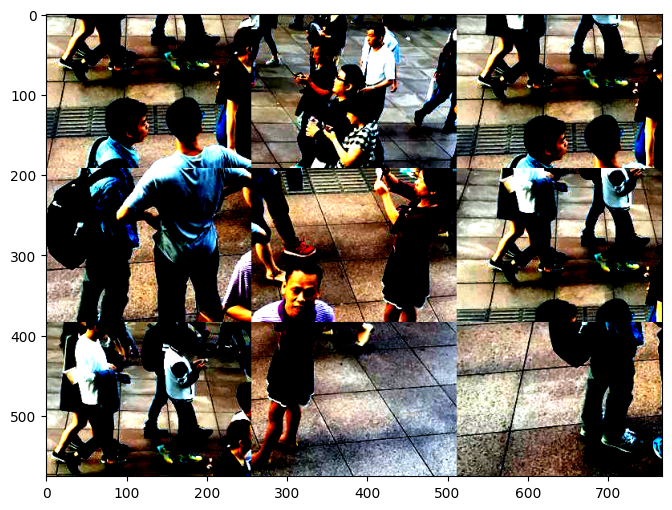

In [20]:
im_new = np.zeros([576, 768, 3])

for i in range(3):
  im_new[0: 0 + 192, (i*256): (i*256) + 256] = im_patch[3*i]
  im_new[192: 192+ 192, (i*256): (i*256) + 256] = im_patch[3*i + 1]
  im_new[(2*192): (2*192)+ 192, (i*256): (i*256) + 256]= im_patch[3*i+ 2]

map_new = np.zeros([576//8, 768//8])

for i in range(3):
  map_new[0: 0 + 192//8, (i*256//8): (i*256//8) + 256//8] = map_patch[3*i]
  map_new[192//8: 192//8+ 192//8, (i*256//8): (i*256//8) + 256//8] = map_patch[3*i + 1]
  map_new[(2*192//8): (2*192//8)+ 192//8, (i*256//8): (i*256//8)+256//8] = map_patch[3*i + 2]

plt.figure(figsize=(10,6))

plt.imshow(im_new)

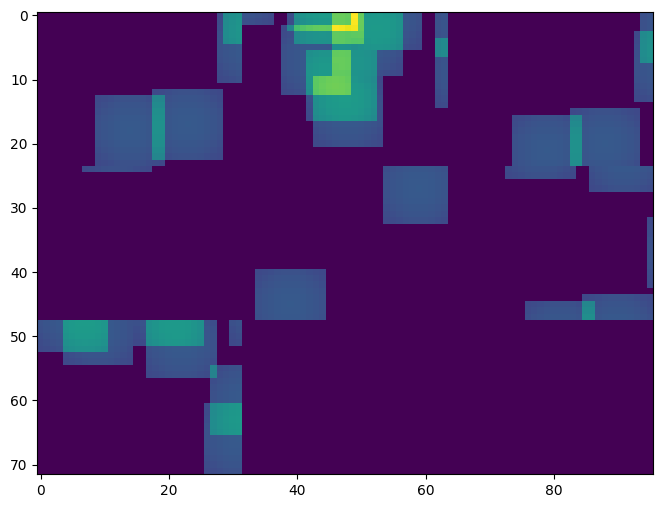

In [21]:
plt.figure(figsize=(10,6))
plt.imshow(map_new)

In [60]:
def generate_new(patch, IN_H, IN_W, is_image=True):
  if(is_image):
     im_new = np.zeros([IN_H, IN_W, 3])
  else:
     im_new = np.zeros([IN_H, IN_W])

  for i in range(3):
    im_new[0: (0+(IN_H//3)), (i*(IN_W//3)): (i*(IN_W//3)) + (IN_W//3)] = patch[3*i]
    im_new[(IN_H//3): (IN_H//3)+ (IN_H//3), (i*(IN_W//3)): (i*(IN_W//3)) + (IN_W//3)] = patch[3*i+1]
    im_new[(2*(IN_H//3)): (2*(IN_H//3))+(IN_H//3), (i*(IN_W//3)): (i*(IN_W//3)) + (IN_W//3)] = patch[3*i+2]
  return im_new

In [64]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size,SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))

    def __getitem__(self, idx):
        X,y = self.__data_generation(idx)
        return X,y

    def __data_generation(self, idx):
        X = []
        y = []
        IN_H = IN_X
        IN_W = IN_Y

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):

            im_array=img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array/=255.
            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            X.append(im_array)
            mat=scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            points=mat['image_info'][0][0][0][0][0]
            points/=self.SUBSAMPLING_FACTOR

            density_map_present=get_density_map_gaussian(im_array,points,gaussian_radius=5)
            y.append(density_map_present)

            patch_1, patch_2= get_patches(768,1024)

            im_patch = []
            for i in range(9):
              im_patch.append(im_array[patch_1[i][0]:patch_1[i][2], patch_1[i][1]:patch_1[i][3]])

            im_patch = tf.constant(im_patch)

            map_patch = []
            for i in range(9):
              map_patch.append(density_map_present[patch_2[i][0]:patch_2[i][2], patch_2[i][1]:patch_2[i][3]])

            IN_H *= 0.75
            IN_W *= 0.75
            IN_H = int(IN_H)
            IN_W = int(IN_W)
            im_gen = generate_new(im_patch, IN_H, IN_W)
            X.append(tf.image.resize(im_gen, [IN_X, IN_Y]))
            map_gen = tf.expand_dims(generate_new(map_patch, IN_H//8, IN_W//8, is_image=False), axis=-1)
            y.append(tf.image.resize(map_gen, [IN_X//8, IN_Y//8])[...,0])


        return tf.stack([X[0], X[1]], axis=0), tf.stack([y[0], y[1]], axis=0)

In [65]:
train_gen = DataGenerator(train_images, train_maps,BATCH_SIZE,SUBSAMPLING_FACTOR)
val_gen = DataGenerator(val_images, val_maps,BATCH_SIZE,SUBSAMPLING_FACTOR)

# Model

In [35]:
def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(None,None,3),
        include_top=False,)

    block4_conv3 = base_model.get_layer("block4_conv3").output

    return Model(inputs=base_model.inputs, outputs=block4_conv3)

get_base_model().summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [36]:
inputs=tf.keras.Input(shape=(None,None,3))
x=get_base_model()(inputs)
init=RandomNormal(0.01)

x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(256, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(128, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(64, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(1, (1,1), activation = 'relu', dilation_rate=1,kernel_initializer=init,padding='same')(x)

out=x[...,0]
model=tf.keras.Model(inputs=inputs,outputs=out)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 model_8 (Functional)        (None, None, None, 512)   7635264   
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 512)   2359808   
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 512)   2359808   
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 512)   2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 256)   1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 128)   2950

In [37]:
def euclidean(y_true, y_pred):
  return tf.sqrt(tf.math.reduce_sum(tf.square(y_true-y_pred)))

In [39]:
LR=1e-5
model.compile(
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    loss = euclidean,
    optimizer = Adam(learning_rate = LR),
    metrics='mae',
    run_eagerly = True,
)

In [40]:
checkpoint_filepath='/'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    verbose=1,
    shuffle=True,
    epochs=EPOCH,
    callbacks=[callback])

Epoch 1/1000
 42/400 [==>...........................] - ETA: 9:33 - loss: 867926336.0000 - mae: 5225075.0000

In [ ]:
IN ='...'

im_array=img_to_array(load_img(train_image+IN_'.jpg',target_size=(IN_X,IN_Y)))
im_array/=255.
im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

plt.figure(figsize=(20,12))
plt.imhow(im_array)

output=model.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(OUT_X,OUT_Y))

n_people=np.sum(output)
mat=scipy.io.loadmat(train_maps+'GT_'+IN+'.mat')
points=mat['image_info'][0][0][0][0][0]
points/=SUBSAMPLING_FACTOR

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)